In [1]:
import mysql.connector as mysql
import database as db
import csv, sys
import image_generator
import new_feature_extractor
import numpy as np
import os
import cv2
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import sklearn.preprocessing as preprocessing
from sklearn import tree
from sklearn import metrics

#### Manually chosen images for train and test set
- Train set: 35 easy and 35 difficult images, total 70
- Test set: 15 easy and 15 difficult images, total 30

In [2]:
train_images = [3, 4, 8, 9, 12, 13, 14, 18, 23, 27, 28, 29, 30, 35, 37, 40, 44, 46, 48, 49, 53, 55, 56, 61, 62, 64, 67, 73, 75, 79, 80, 85, 91, 94, 97, 1, 2, 5, 7, 11, 16, 17, 21, 22, 25, 32, 33, 41, 42, 47, 58, 59, 63, 65, 68, 71, 74, 76, 77, 78, 81, 83, 84, 86, 88, 90, 93, 96, 100, 105]
test_images = [128, 130, 133, 143, 147, 149, 153, 157, 158, 161, 168, 174, 178, 208, 211, 127, 131, 134, 135, 137, 138, 146, 148, 151, 160, 165, 166, 169, 196, 201]

Both train and test sets are split evenly, 50% seem to be easy images, and 50% dififcult

In [3]:
data = pd.read_csv("feature_values_normalized.csv") #My generated file with normalized and scaled values
data.head()

,filename,Mobilenet_v1,Inception_v4,Resnet_v1_152,kp_surf,average_perceived_brightness,contrast,area_by_perim,aspect_ratio,edge_length1,hue1
0,ILSVRC2012_val_00000001.JPEG,1,0,0,0.215091,0.065363,-0.451898,-0.412354,0.549662,-0.177778,-0.375721
1,ILSVRC2012_val_00000002.JPEG,0,0,0,0.258320,-0.291292,-0.403386,-0.484455,0.067587,-0.490910,-0.519526
2,ILSVRC2012_val_00000003.JPEG,1,0,0,0.183594,-0.072210,-0.055869,0.355121,-0.068961,0.009978,0.127935
3,ILSVRC2012_val_00000004.JPEG,1,0,0,-0.232609,0.972640,0.382620,0.916105,0.519454,1.158174,0.839255
4,ILSVRC2012_val_00000005.JPEG,0,1,0,0.265121,-0.370515,-0.380947,-0.272975,-0.303711,-0.612450,-0.369234


In [4]:
temp = [x-1 for x in train_images]
train = data.iloc[temp]
temp = [x-1 for x in test_images]
test = data.iloc[temp]

Visualizing Easy and Difficult images in the test set

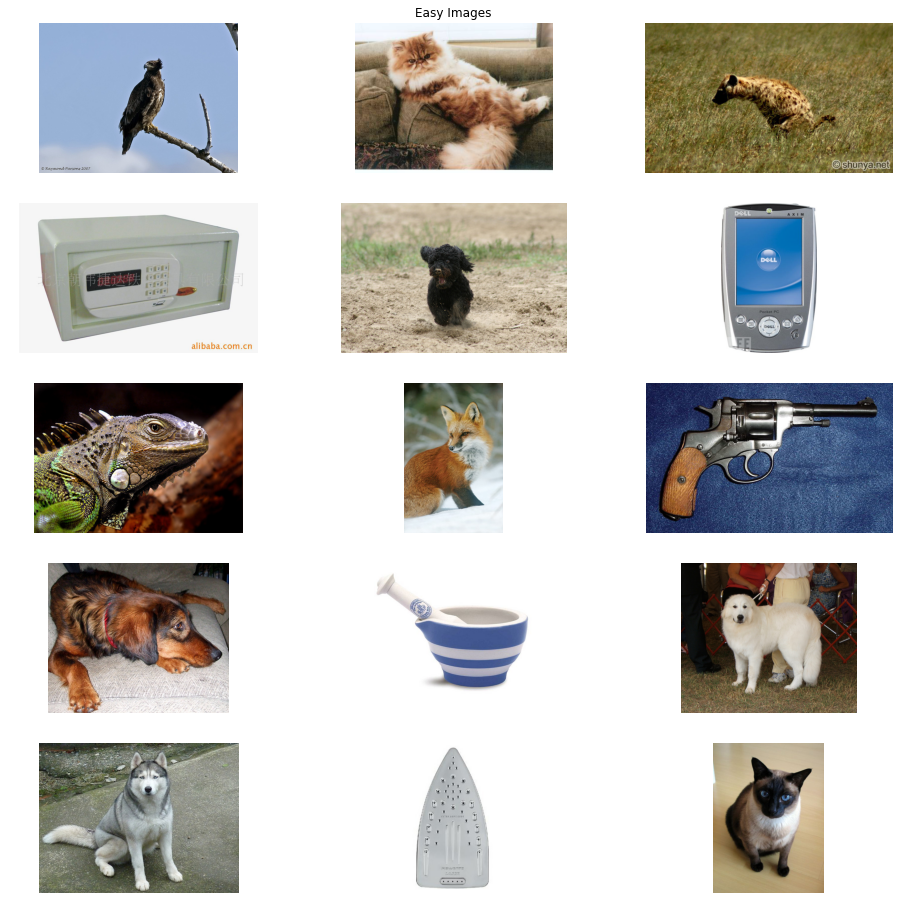

In [5]:
%matplotlib inline
from matplotlib.pyplot import figure
import matplotlib.image as mpimg
temp = test['filename'].tolist()
w=10
h=10
fig=plt.figure(figsize=(16, 16))
plt.title('Easy Images')
plt.axis('off')
columns = 3
rows = 5
for i in range(1, columns*rows +1):
    img = mpimg.imread('images/val/images/' + temp[i-1])
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(img)
plt.show()

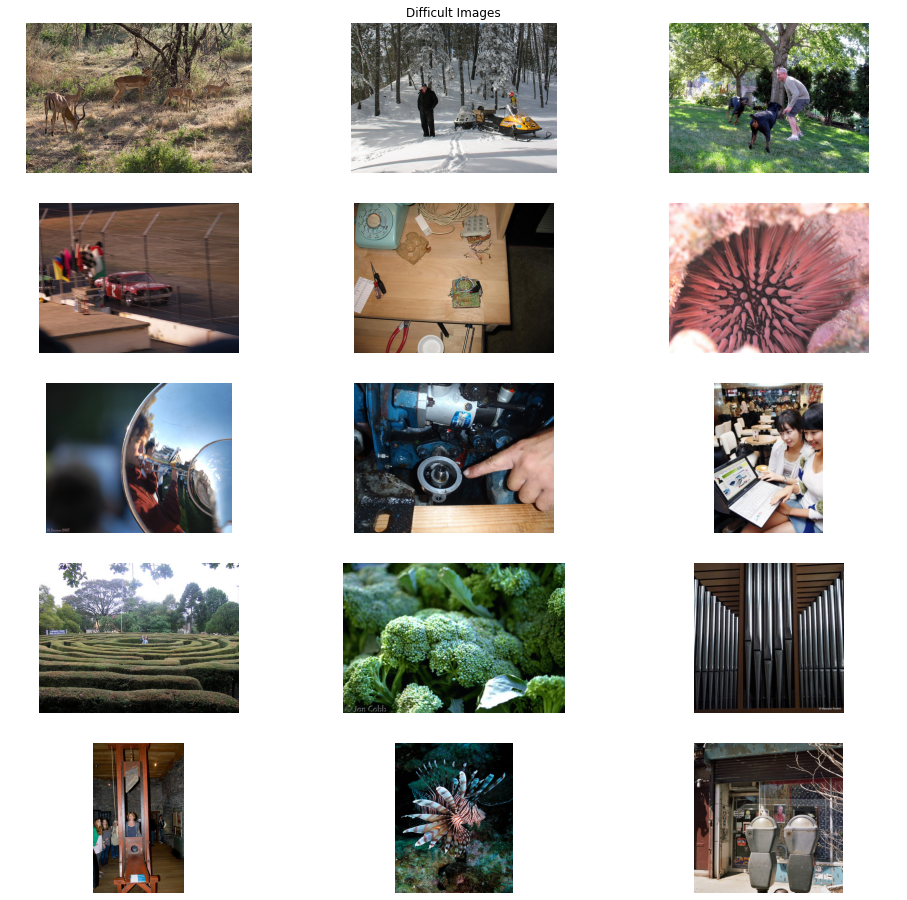

In [6]:
fig=plt.figure(figsize=(16, 16))
plt.title('Difficult Images')
plt.axis('off')
for i in range(1, columns*rows +1):
    img = mpimg.imread('images/val/images/' + temp[i+14])
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(img)
plt.show()

In [7]:
X_train = train.drop(['Mobilenet_v1', 'Inception_v4', 'Resnet_v1_152', 'filename', 'contrast', 'area_by_perim', 'edge_length1'], axis = 1)
X_test = test.drop(['Mobilenet_v1', 'Inception_v4', 'Resnet_v1_152', 'filename', 'contrast', 'area_by_perim', 'edge_length1'], axis = 1)
Y_train = train[['Mobilenet_v1']]
Y_test = test[['Mobilenet_v1']]

# X_train = train.drop(['Mobilnet_v1', 'Inception_v4', 'Resnet_v_152', 'filename', 'contrast', 'area_by_perim', 'edge_count'], axis = 1)
# X_test = test.drop(['Mobilnet_v1', 'Inception_v4', 'Resnet_v_152', 'filename', 'contrast', 'area_by_perim', 'edge_count'], axis = 1)
# Y_train = train[['Mobilnet_v1']]
# Y_test = test[['Mobilnet_v1']]

In [8]:
test

,filename,Mobilenet_v1,Inception_v4,Resnet_v1_152,kp_surf,average_perceived_brightness,contrast,area_by_perim,aspect_ratio,edge_length1,hue1
127,ILSVRC2012_val_00000128.JPEG,0,0,0,0.198180,0.317853,-0.103068,-0.103646,-0.237300,-0.211901,-0.483975
129,ILSVRC2012_val_00000130.JPEG,1,0,0,0.197271,0.000554,0.070444,0.119503,-0.092305,-0.085508,0.155159
132,ILSVRC2012_val_00000133.JPEG,1,0,0,0.270430,-0.471078,-0.568132,-0.434624,-0.309881,-0.676029,-0.297920
142,ILSVRC2012_val_00000143.JPEG,1,0,0,0.063609,0.507198,-0.029037,1.295803,0.173634,0.293092,-0.047898
146,ILSVRC2012_val_00000147.JPEG,1,0,0,0.256990,-0.120299,-0.326414,-0.431227,-0.351079,-0.580201,-0.033338
148,ILSVRC2012_val_00000149.JPEG,1,0,0,0.051307,0.155789,0.010698,0.603331,-0.234119,0.558975,-0.444131
152,ILSVRC2012_val_00000153.JPEG,1,0,0,0.271648,-0.518098,-0.416955,-0.369995,-0.328706,-0.739863,-0.322793
156,ILSVRC2012_val_00000157.JPEG,1,0,0,-0.046743,1.564428,1.505741,0.886972,0.356195,0.025880,0.535860
157,ILSVRC2012_val_00000158.JPEG,1,0,0,0.270918,-0.507694,-0.507631,-0.213839,-0.292435,-0.756373,-0.499550
160,ILSVRC2012_val_00000161.JPEG,0,0,0,0.265471,-0.380379,-0.330266,-0.213570,-0.316405,-0.635806,-0.238041


# Decision Tree
### Training and testing accuracy for each maximum depth in range(1, 20)

In [9]:
trees = []
for x in range(1, 21):
    tree_model = DecisionTreeClassifier(max_depth=x)
    tree_model.fit(X_train, Y_train)
    print("Depth:", x)
    print("Decision tree accuracy on training set =", tree_model.score(X_train, Y_train))
    print("Decision tree accuracy on test set =", tree_model.score(X_test, Y_test))
    print()
    trees.append(tree_model)

Depth: 1
Decision tree accuracy on training set = 0.7142857142857143
Decision tree accuracy on test set = 0.8333333333333334

Depth: 2
Decision tree accuracy on training set = 0.7142857142857143
Decision tree accuracy on test set = 0.8333333333333334

Depth: 3
Decision tree accuracy on training set = 0.8
Decision tree accuracy on test set = 0.7

Depth: 4
Decision tree accuracy on training set = 0.8857142857142857
Decision tree accuracy on test set = 0.6333333333333333

Depth: 5
Decision tree accuracy on training set = 0.9428571428571428
Decision tree accuracy on test set = 0.6666666666666666

Depth: 6
Decision tree accuracy on training set = 0.9571428571428572
Decision tree accuracy on test set = 0.6333333333333333

Depth: 7
Decision tree accuracy on training set = 0.9857142857142858
Decision tree accuracy on test set = 0.6333333333333333

Depth: 8
Decision tree accuracy on training set = 1.0
Decision tree accuracy on test set = 0.6333333333333333

Depth: 9
Decision tree accuracy on tr

### Feature importance for each built tree

[0. 1. 0. 0.]


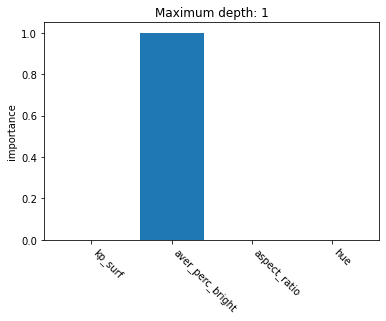

[0. 1. 0. 0.]


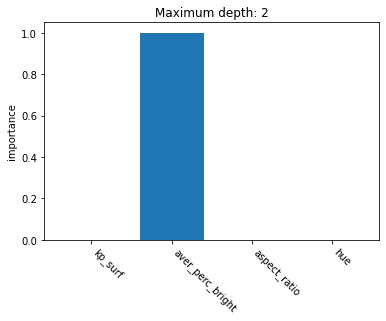

[0.        0.4895295 0.5104705 0.       ]


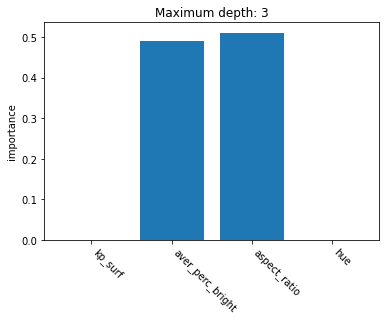

[0.         0.4931704  0.39253352 0.11429608]


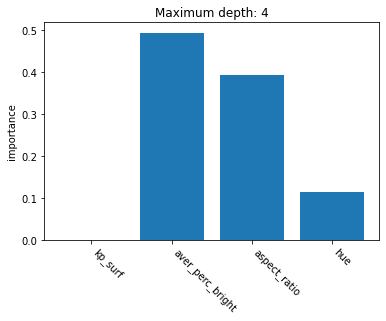

[0.07939509 0.48599748 0.27966261 0.15494482]


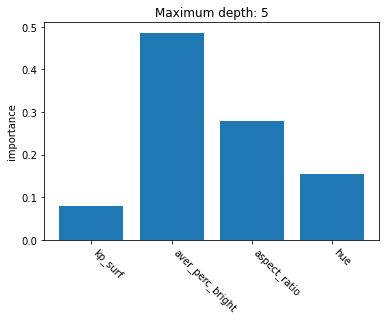

[0.07382813 0.4409832  0.26005345 0.22513522]


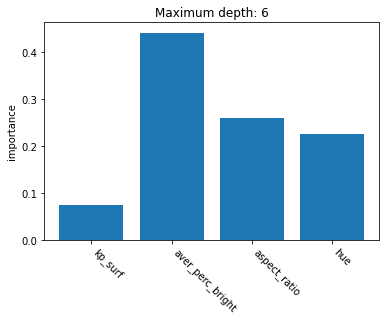

[0.06690265 0.44917416 0.27990685 0.20401634]


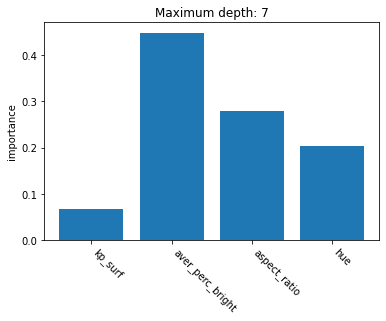

[0.063      0.42297233 0.33357895 0.18044872]


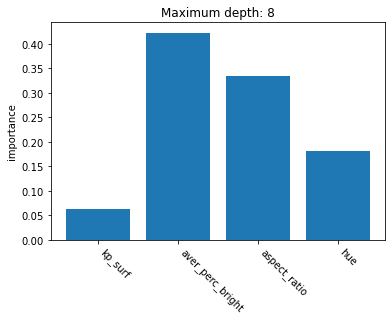

[0.098      0.42297233 0.28691228 0.19211538]


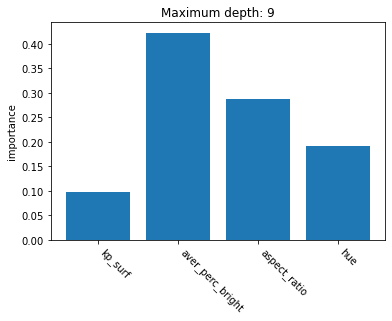

[0.063      0.504639   0.28691228 0.14544872]


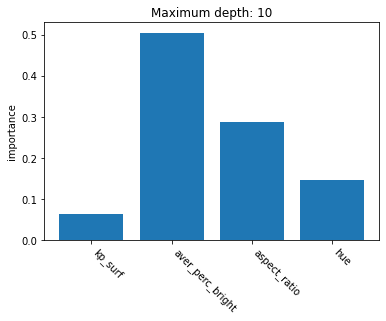

[0.10966667 0.41130567 0.28691228 0.19211538]


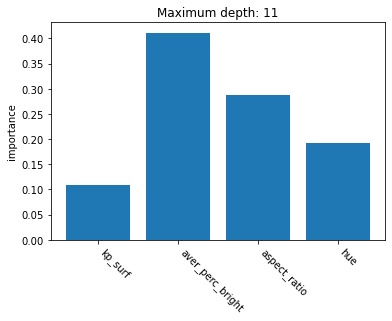

[0.098      0.42297233 0.28691228 0.19211538]


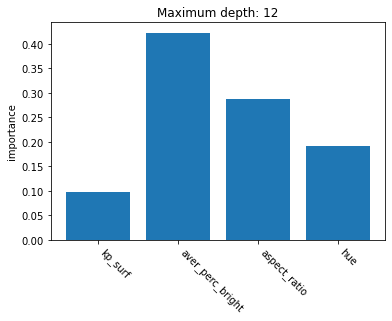

[0.098      0.469639   0.28691228 0.14544872]


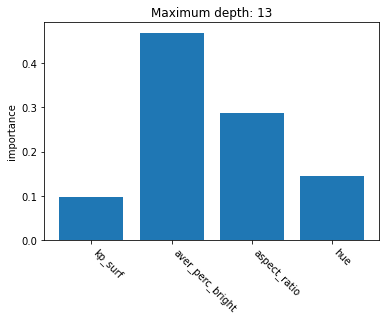

[0.063      0.42297233 0.32191228 0.19211538]


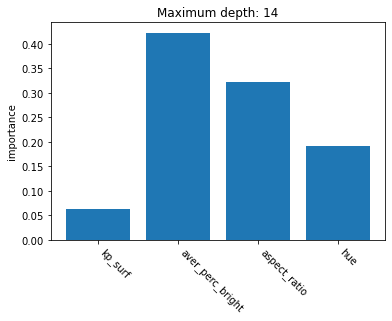

[0.063      0.42297233 0.32191228 0.19211538]


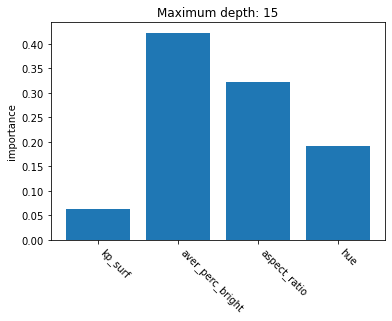

[0.098      0.37630567 0.28691228 0.23878205]


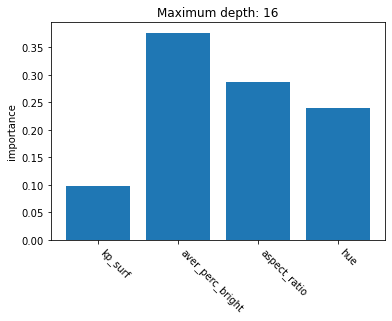

[0.098      0.37630567 0.33357895 0.19211538]


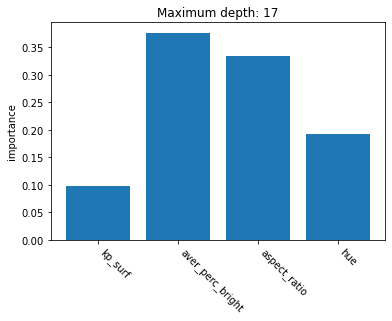

[0.063      0.41130567 0.28691228 0.23878205]


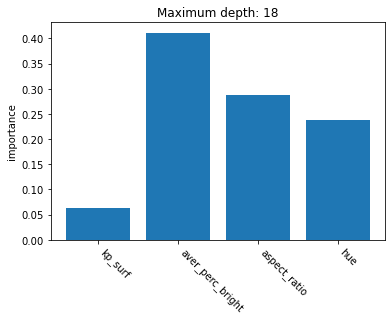

[0.063      0.42297233 0.28691228 0.22711538]


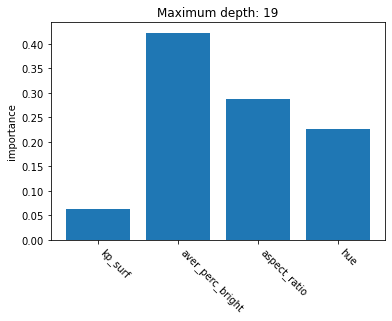

[0.10966667 0.45797233 0.28691228 0.14544872]


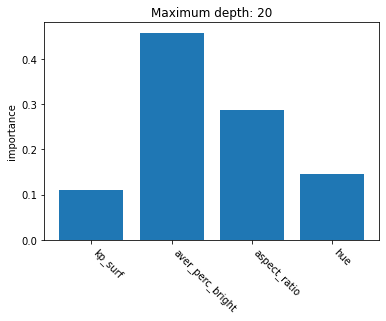

In [10]:
for x in range(len(trees)):
    feature_names = ['kp_surf', 'aver_perc_bright', 'aspect_ratio', 'hue']
#     feature_names = ['kp_surf', 'aver_perc_bright', 'contrast', 'area_by_perim', 'aspect_ratio', 'edge_length', 'hue']
    ypos = np.arange(len(feature_names))

    plt.xticks(ypos, feature_names)
    plt.ylabel("importance")
    plt.title("Maximum depth: {}".format(x+1))
    plt.bar(ypos, trees[x].feature_importances_)
    plt.xticks(rotation=-45, ha='left')
    print(trees[x].feature_importances_)
    plt.show()

### Split between classes for each built tree

In [11]:

for x in range(len(trees)):

    prediction = trees[x].predict(X_test)
    results = [0, 0, 0, 0]
    for y in prediction:
        if y == 1:
            results[0] += 1
        else:
            results[3] += 1
    print('Maximum Depth: ', x+1)
    print('MobileNet: {}%\nOther: {}%\n'.format
          (
        round(results[0]/len(prediction)*100, 2), 
        round(results[3]/len(prediction)*100, 2)
    )
         )

Maximum Depth:  1
MobileNet: 100.0%
Other: 0.0%

Maximum Depth:  2
MobileNet: 100.0%
Other: 0.0%

Maximum Depth:  3
MobileNet: 80.0%
Other: 20.0%

Maximum Depth:  4
MobileNet: 66.67%
Other: 33.33%

Maximum Depth:  5
MobileNet: 70.0%
Other: 30.0%

Maximum Depth:  6
MobileNet: 66.67%
Other: 33.33%

Maximum Depth:  7
MobileNet: 66.67%
Other: 33.33%

Maximum Depth:  8
MobileNet: 66.67%
Other: 33.33%

Maximum Depth:  9
MobileNet: 66.67%
Other: 33.33%

Maximum Depth:  10
MobileNet: 66.67%
Other: 33.33%

Maximum Depth:  11
MobileNet: 66.67%
Other: 33.33%

Maximum Depth:  12
MobileNet: 66.67%
Other: 33.33%

Maximum Depth:  13
MobileNet: 66.67%
Other: 33.33%

Maximum Depth:  14
MobileNet: 66.67%
Other: 33.33%

Maximum Depth:  15
MobileNet: 66.67%
Other: 33.33%

Maximum Depth:  16
MobileNet: 66.67%
Other: 33.33%

Maximum Depth:  17
MobileNet: 66.67%
Other: 33.33%

Maximum Depth:  18
MobileNet: 66.67%
Other: 33.33%

Maximum Depth:  19
MobileNet: 66.67%
Other: 33.33%

Maximum Depth:  20
MobileNet:

### Visualization of each tree 

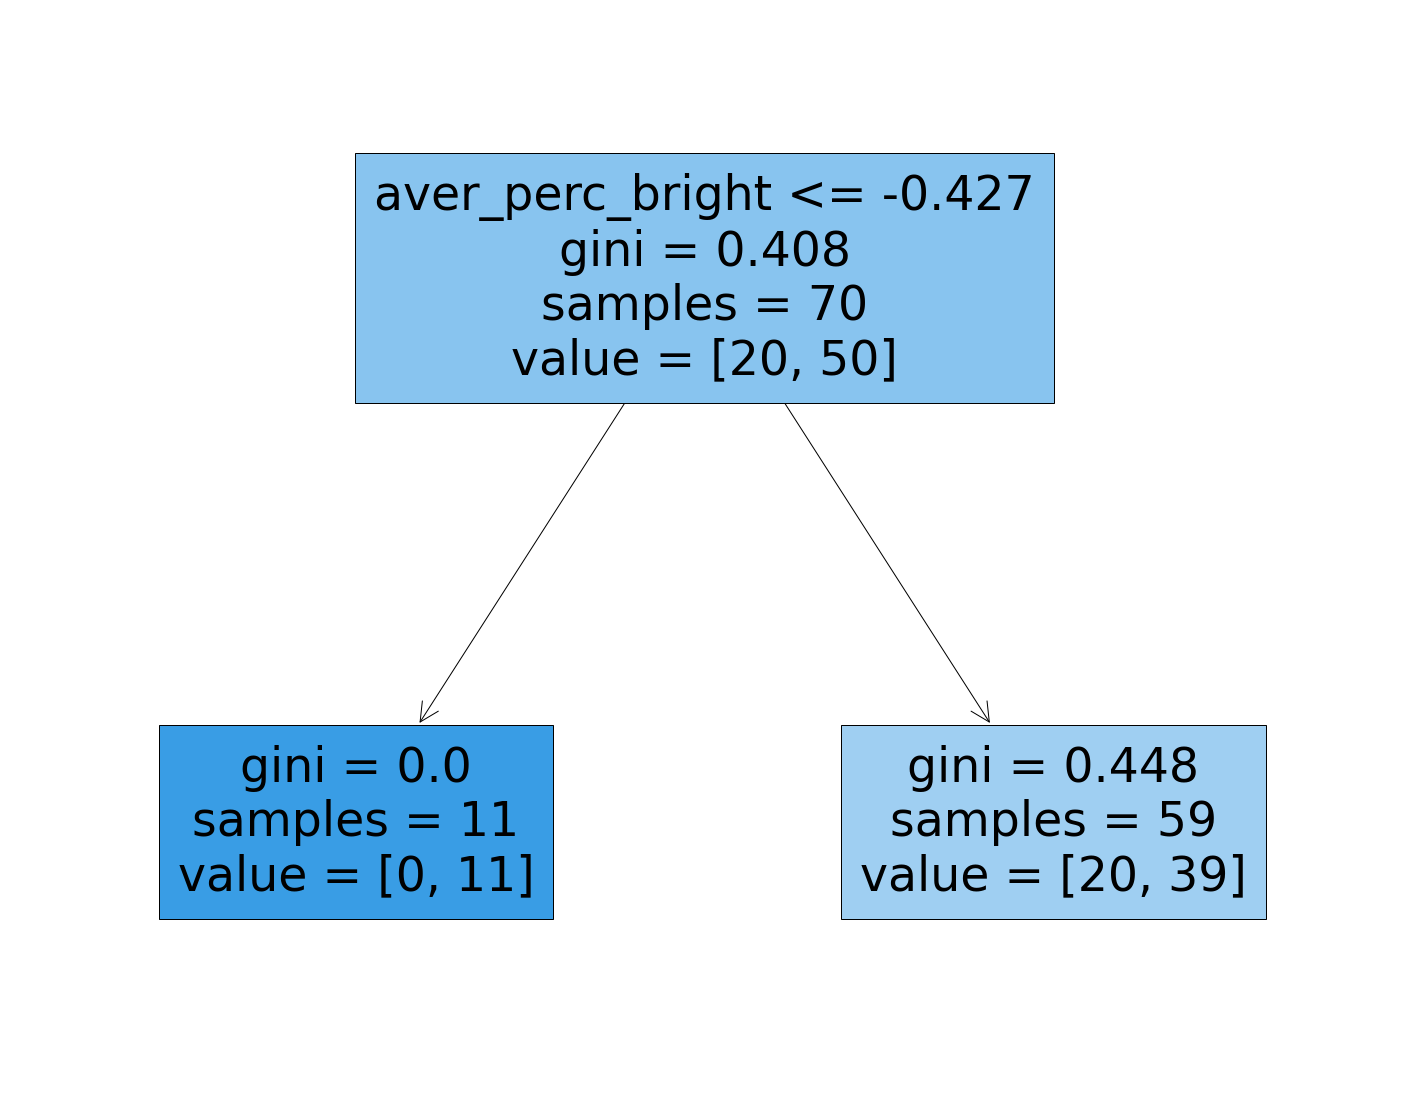

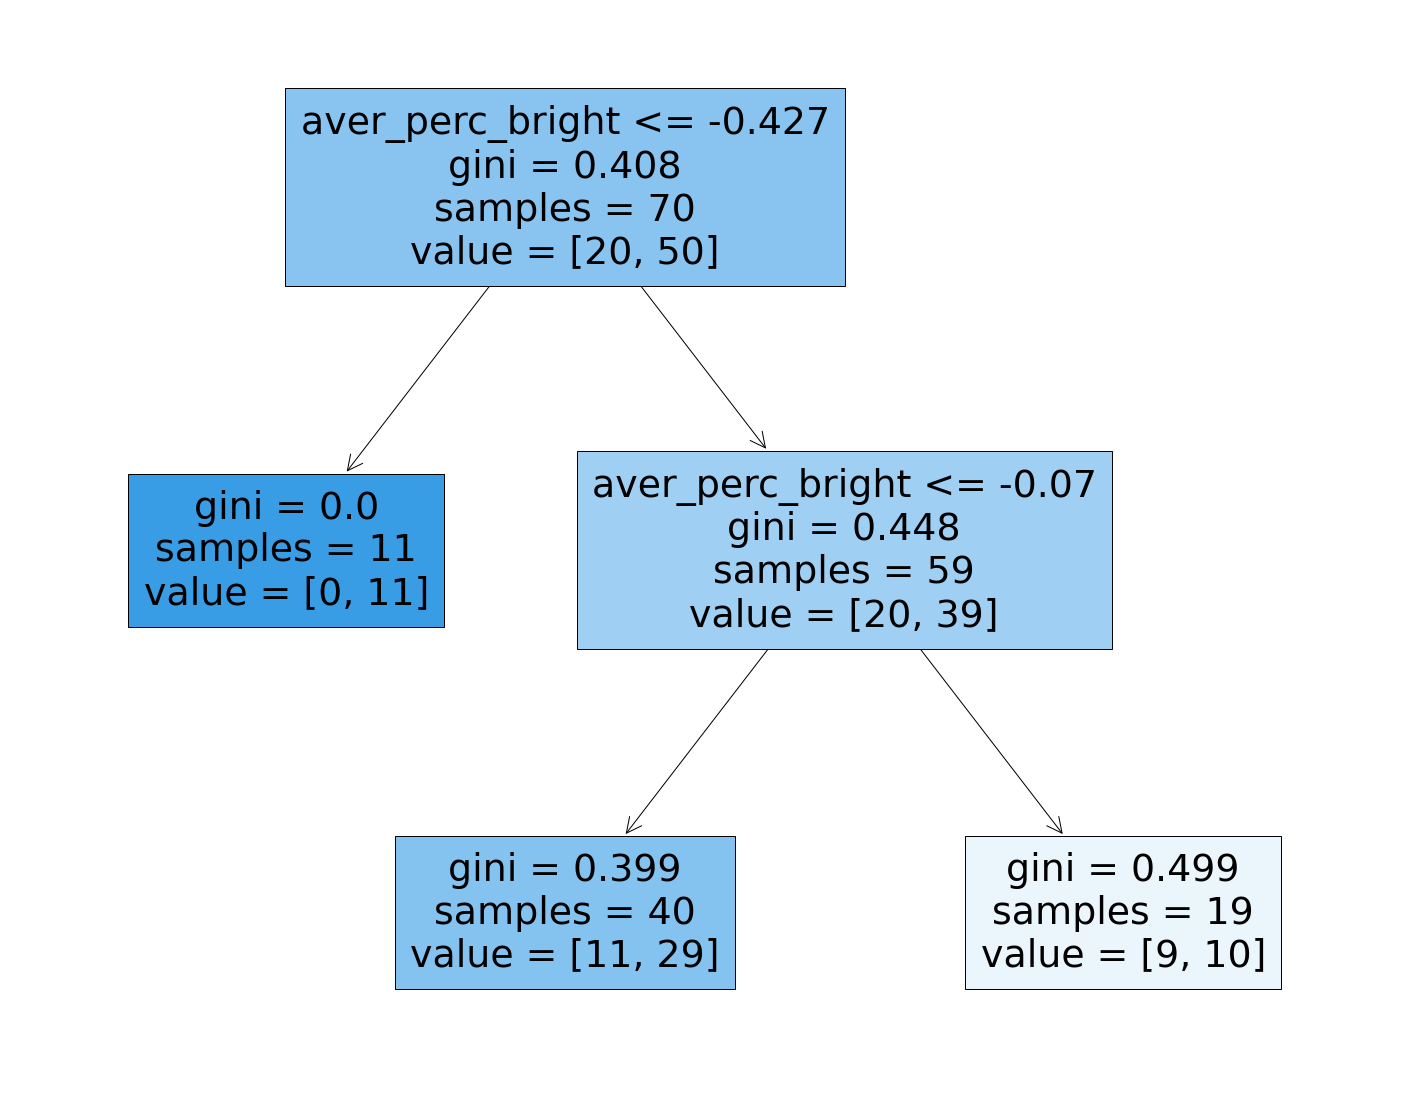

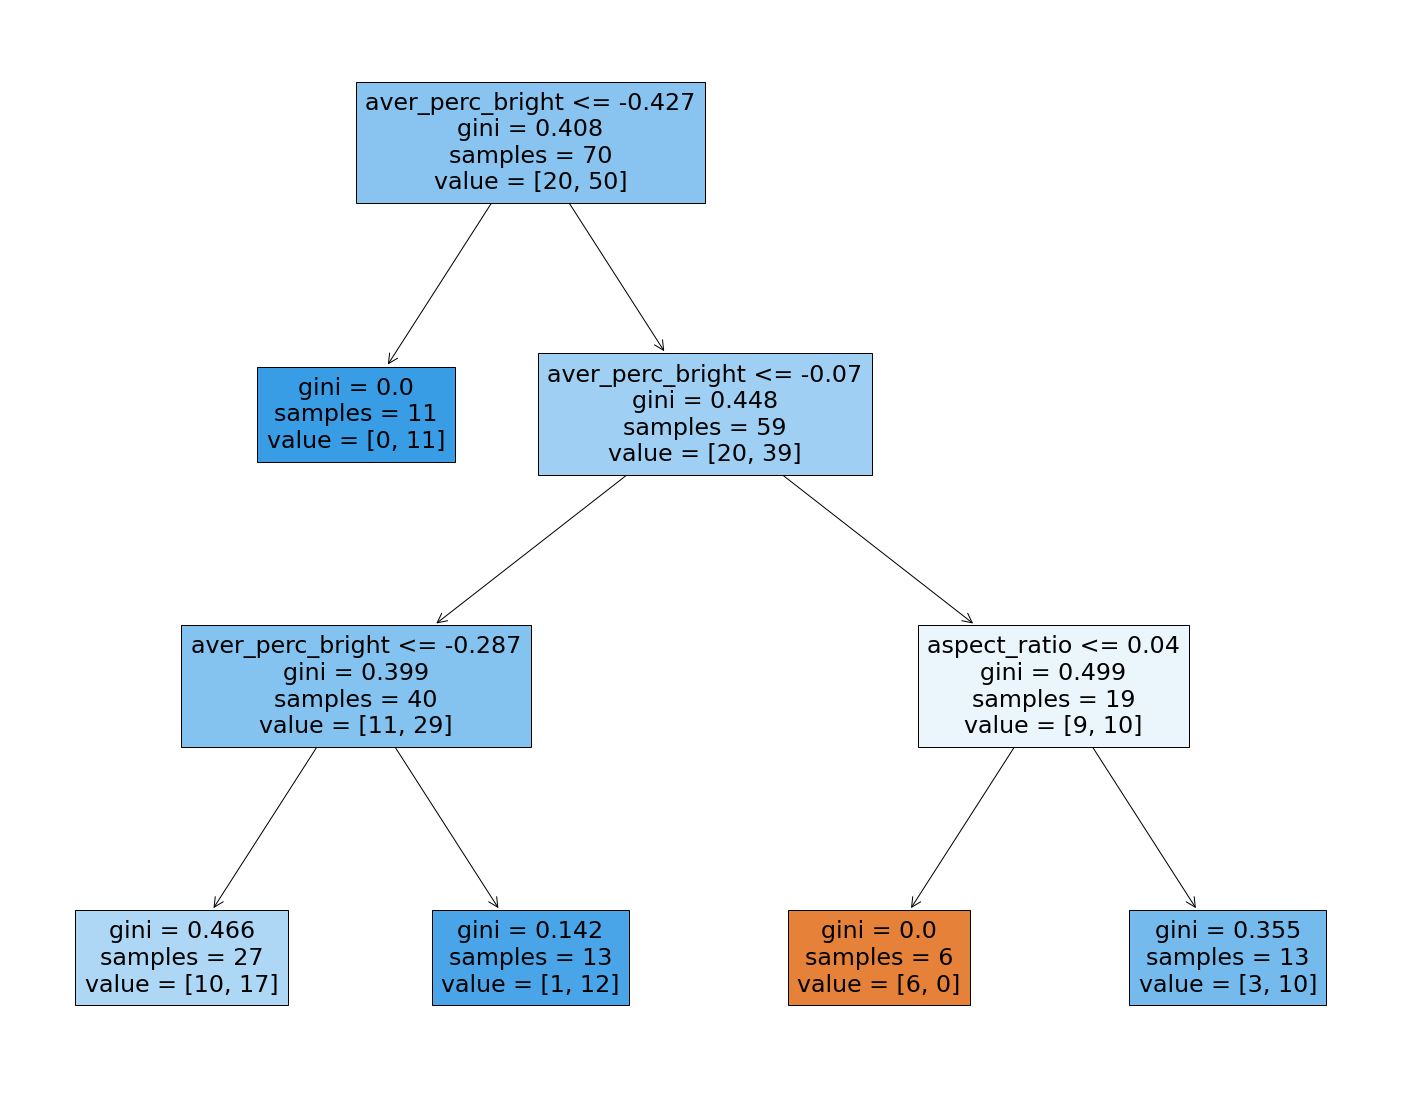

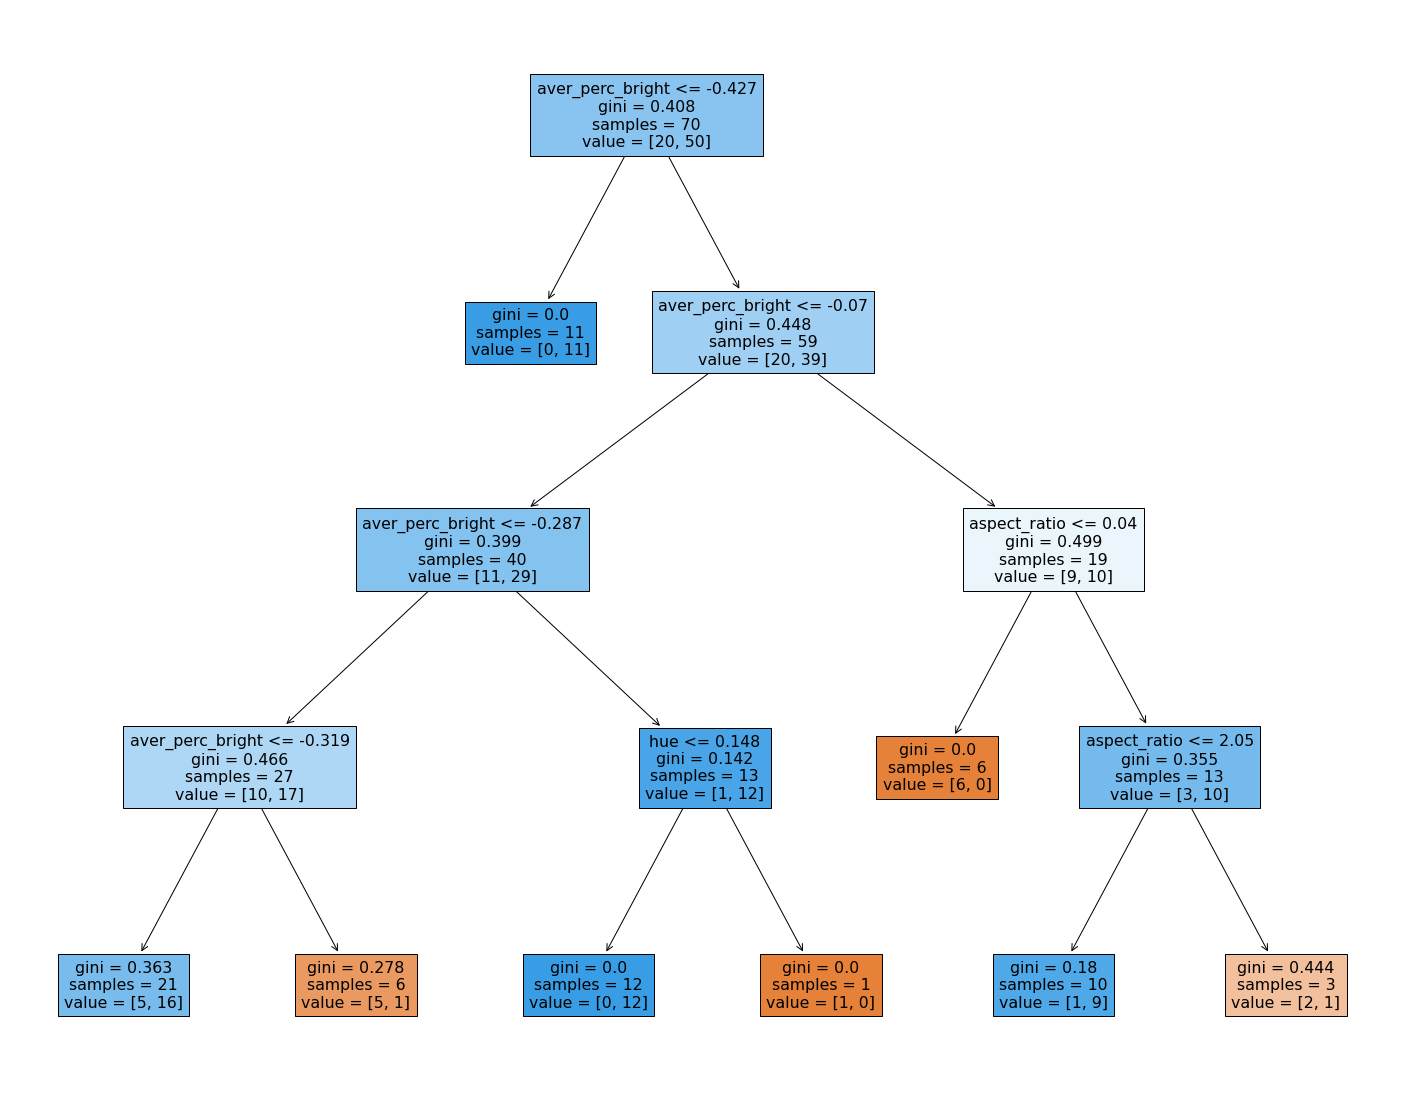

In [12]:
from sklearn.tree import plot_tree
for x in range(4):
    fig = plt.figure(figsize=(25,20))
    plot_tree(trees[x], 
                       feature_names=feature_names,  
                       filled=True)

# Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train, Y_train)
print("Logistic regression accuracy on training set =", log_reg_model.score(X_train, Y_train))
print("Logistic regression accuracy on test set =", log_reg_model.score(X_test, Y_test))

Logistic regression accuracy on training set = 0.7428571428571429
Logistic regression accuracy on test set = 0.8333333333333334


LR accuracy on test set = 0.8333333333333334


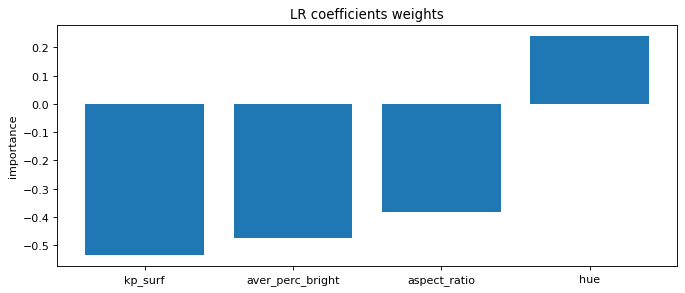

In [14]:
from matplotlib.pyplot import figure
print("LR accuracy on test set =", log_reg_model.score(X_test, Y_test))
feature_names = ['kp_surf', 'aver_perc_bright', 'aspect_ratio', 'hue']
# feature_names = ['kp_surf', 'aver_perc_bright', 'contrast', 'area_by_perim', 'aspect_ratio', 'edge_length', 'hue']

figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
ypos = np.arange(len(feature_names))

plt.xticks(ypos, feature_names)
plt.ylabel("importance")
plt.title("LR coefficients weights")
plt.bar(ypos, log_reg_model.coef_[0])
plt.show()

# KNN Classifier

In [15]:
from sklearn.neighbors import KNeighborsClassifier
knns = []
for x in range(1, 11):
    knn_model = KNeighborsClassifier(n_neighbors=x)
    knn_model.fit(X_train, Y_train)
    print("N_neighbors =", x)
    print("KNN accuracy on training set =", knn_model.score(X_train, Y_train))
    print("KNN accuracy on test set =", knn_model.score(X_test, Y_test))
    print()
    knns.append(knn_model)

N_neighbors = 1
KNN accuracy on training set = 1.0
KNN accuracy on test set = 0.7333333333333333

N_neighbors = 2
KNN accuracy on training set = 0.7428571428571429
KNN accuracy on test set = 0.6

N_neighbors = 3
KNN accuracy on training set = 0.7428571428571429
KNN accuracy on test set = 0.7333333333333333

N_neighbors = 4
KNN accuracy on training set = 0.7142857142857143
KNN accuracy on test set = 0.6666666666666666

N_neighbors = 5
KNN accuracy on training set = 0.7428571428571429
KNN accuracy on test set = 0.7

N_neighbors = 6
KNN accuracy on training set = 0.7285714285714285
KNN accuracy on test set = 0.6666666666666666

N_neighbors = 7
KNN accuracy on training set = 0.7714285714285715
KNN accuracy on test set = 0.7333333333333333

N_neighbors = 8
KNN accuracy on training set = 0.7714285714285715
KNN accuracy on test set = 0.6666666666666666

N_neighbors = 9
KNN accuracy on training set = 0.7285714285714285
KNN accuracy on test set = 0.7666666666666667

N_neighbors = 10
KNN accurac

# Random Forest Classifier

In [16]:
from sklearn.ensemble import RandomForestClassifier
forest_model = RandomForestClassifier(max_depth=2, random_state=0)
forest_model.fit(X_train, Y_train)
print("Random Forest accuracy on training set =", forest_model.score(X_train, Y_train))
print("Random Forest accuracy on test set =", forest_model.score(X_test, Y_test))
print()

Random Forest accuracy on training set = 0.7285714285714285
Random Forest accuracy on test set = 0.8333333333333334



### Decision Trees with 4 classes

In [17]:
X_train = train.drop(['Mobilenet_v1', 'Inception_v4', 'Resnet_v1_152', 'filename'], axis = 1)
X_test = test.drop(['Mobilenet_v1', 'Inception_v4', 'Resnet_v1_152', 'filename'], axis = 1)
Y_train = train[['Mobilenet_v1', 'Inception_v4', 'Resnet_v1_152']]
Y_test = test[['Mobilenet_v1', 'Inception_v4', 'Resnet_v1_152']]

In [18]:
trees = []
for x in range(1, 21):
    tree_model = DecisionTreeClassifier(max_depth=x)
    tree_model.fit(X_train, Y_train)
    print("Depth:", x)
    print("Decision tree accuracy on training set =", tree_model.score(X_train, Y_train))
    print("Decision tree accuracy on test set =", tree_model.score(X_test, Y_test))
    print()
    trees.append(tree_model)

Depth: 1
Decision tree accuracy on training set = 0.7142857142857143
Decision tree accuracy on test set = 0.8333333333333334

Depth: 2
Decision tree accuracy on training set = 0.7142857142857143
Decision tree accuracy on test set = 0.8

Depth: 3
Decision tree accuracy on training set = 0.7428571428571429
Decision tree accuracy on test set = 0.8

Depth: 4
Decision tree accuracy on training set = 0.7714285714285715
Decision tree accuracy on test set = 0.6666666666666666

Depth: 5
Decision tree accuracy on training set = 0.8285714285714286
Decision tree accuracy on test set = 0.6333333333333333

Depth: 6
Decision tree accuracy on training set = 0.8857142857142857
Decision tree accuracy on test set = 0.5666666666666667

Depth: 7
Decision tree accuracy on training set = 0.9285714285714286
Decision tree accuracy on test set = 0.5

Depth: 8
Decision tree accuracy on training set = 0.9714285714285714
Decision tree accuracy on test set = 0.5666666666666667

Depth: 9
Decision tree accuracy on tr

In [19]:
for x in range(len(trees)):

    prediction = trees[x].predict(X_test)
    results = [0, 0, 0, 0]
    for y in prediction:
        if y.tolist() == [1, 0, 0]:
            results[0] += 1
        elif y.tolist() == [0, 1, 0]:
            results[1] += 1
        elif y.tolist() == [0, 0, 1]:
            results[2] += 1
        else:
            results[3] += 1
    print('Maximum Depth: ', x+1)
    print('MobileNet: {}%\nInception: {}%\nResNet: {}%\nOther: {}%\n'.format
          (
        round(results[0]/len(prediction)*100, 2), 
        round(results[1]/len(prediction)*100, 2), 
        round(results[2]/len(prediction)*100, 2), 
        round(results[3]/len(prediction)*100, 2)
    )
         )

Maximum Depth:  1
MobileNet: 100.0%
Inception: 0.0%
ResNet: 0.0%
Other: 0.0%

Maximum Depth:  2
MobileNet: 96.67%
Inception: 0.0%
ResNet: 3.33%
Other: 0.0%

Maximum Depth:  3
MobileNet: 96.67%
Inception: 0.0%
ResNet: 3.33%
Other: 0.0%

Maximum Depth:  4
MobileNet: 76.67%
Inception: 0.0%
ResNet: 3.33%
Other: 20.0%

Maximum Depth:  5
MobileNet: 66.67%
Inception: 0.0%
ResNet: 3.33%
Other: 30.0%

Maximum Depth:  6
MobileNet: 63.33%
Inception: 3.33%
ResNet: 20.0%
Other: 13.33%

Maximum Depth:  7
MobileNet: 60.0%
Inception: 3.33%
ResNet: 20.0%
Other: 16.67%

Maximum Depth:  8
MobileNet: 60.0%
Inception: 3.33%
ResNet: 13.33%
Other: 23.33%

Maximum Depth:  9
MobileNet: 60.0%
Inception: 3.33%
ResNet: 13.33%
Other: 23.33%

Maximum Depth:  10
MobileNet: 63.33%
Inception: 0.0%
ResNet: 20.0%
Other: 16.67%

Maximum Depth:  11
MobileNet: 63.33%
Inception: 3.33%
ResNet: 10.0%
Other: 23.33%

Maximum Depth:  12
MobileNet: 60.0%
Inception: 3.33%
ResNet: 13.33%
Other: 23.33%

Maximum Depth:  13
MobileNet:

### Logistic Regression with 4 classes

In [20]:
log_reg_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
train = []
test = []
for x in range(len(Y_train)):
    if Y_train.iloc[x].tolist() == [1, 0, 0]:
        train.append(0)
    elif Y_train.iloc[x].tolist() == [0, 1, 0]:
        train.append(1)
    elif Y_train.iloc[x].tolist() == [0, 0, 1]:
        train.append(2)
    else:
        train.append(3)
for x in range(len(Y_test)):
    if Y_test.iloc[x].tolist() == [1, 0, 0]:
        test.append(0)
    elif Y_test.iloc[x].tolist() == [0, 1, 0]:
        test.append(1)
    elif Y_test.iloc[x].tolist() == [0, 0, 1]:
        test.append(2)
    else:
        test.append(3)
        
Y_train = pd.DataFrame(train)
Y_test = pd.DataFrame(test)  
log_reg_model.fit(X_train, train)
print("Logistic regression accuracy on training set =", log_reg_model.score(X_train, Y_train))
print("Logistic regression accuracy on test set =", log_reg_model.score(X_test, Y_test))

Logistic regression accuracy on training set = 0.7428571428571429
Logistic regression accuracy on test set = 0.8333333333333334


LR accuracy on test set = 0.8333333333333334


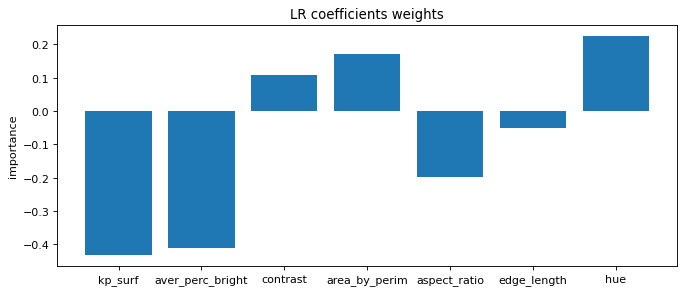

In [21]:
print("LR accuracy on test set =", log_reg_model.score(X_test, Y_test))

feature_names = ['kp_surf', 'aver_perc_bright', 'contrast', 'area_by_perim', 'aspect_ratio', 'edge_length', 'hue']

figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
ypos = np.arange(len(feature_names))

plt.xticks(ypos, feature_names)
plt.ylabel("importance")
plt.title("LR coefficients weights")
plt.bar(ypos, log_reg_model.coef_[0])
plt.show()

In [22]:
log_reg_model.coef_[0]

array([-0.43261792, -0.41123219,  0.1071645 ,  0.16945147, -0.19672269,
       -0.05179924,  0.22541856])